In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import itertools
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Input, Concatenate
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.layers import LeakyReLU
from keras.utils import plot_model


In [2]:
def get_m_values(df):
    e_sum_sq = np.power(df['E1'] + df['E2'] + df['E3'] + df['E4'], 2)
    x_sum_sq = np.power(df['p1x'] + df['p2x'] + df['p3x'] + df['p4x'], 2)
    y_sum_sq = np.power(df['p1y'] + df['p2y'] + df['p3y'] + df['p4y'], 2)
    z_sum_sq = np.power(df['p1z'] + df['p2z'] + df['p3z'] + df['p4z'], 2)
    m_values = np.sqrt(e_sum_sq - x_sum_sq - y_sum_sq - z_sum_sq)
    return m_values

# Data prep

In [3]:
data_raw = pd.read_csv('../data/pp_4l_all.csv')
data_raw

,pdg1,E1,p1x,p1y,p1z,pdg2,E2,p2x,p2y,p2z,pdg3,E3,p3x,p3y,p3z,pdg4,E4,p4x,p4y,p4z
0,11,20.274241,13.753708,1.397849,14.829915,-11,13.459523,-13.458053,-0.178631,0.087476,13,10.726935,1.457106,-9.715445,-4.306151,-13,19.941356,-1.752761,8.496227,17.955180
1,13,152.820099,63.584427,18.996694,-137.659427,-13,164.917905,4.471840,31.646155,-161.791309,13,137.529487,-39.586901,-44.338982,-124.021291,-13,39.559938,-28.469366,-6.303867,-26.734509
2,11,51.267102,27.995380,26.039697,34.154190,-11,43.013595,-7.827488,-17.337374,-38.578689,13,123.210062,0.378806,-41.833551,115.890116,-13,46.883635,-20.546697,33.131228,26.042638
3,13,64.805282,-3.653628,46.355274,45.139262,-13,38.158727,-29.094263,-15.298609,-19.379208,13,57.805237,34.629435,10.578369,45.059234,-13,42.993259,-1.881544,-41.635034,10.554281
4,13,25.501529,17.607195,-7.617831,-16.800957,-13,22.270427,3.366801,16.786119,-14.242599,13,36.269401,-21.935459,13.187325,-25.698023,-13,47.012227,0.961463,-22.355613,-41.345380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,13,104.780662,42.444194,-70.801849,64.533437,-13,40.669899,15.498023,29.488293,23.329839,13,70.717828,-10.422217,-15.453176,68.217130,-13,76.806457,-47.520000,56.766732,20.459923
19996,11,41.767784,24.968553,-8.233132,32.455118,-11,70.293006,-59.382010,26.894480,26.297730,13,13.512633,5.146302,-11.949588,-3.647330,-13,35.067493,29.267155,-6.711760,18.113636
19997,13,165.372773,42.569775,-26.508450,-157.585720,-13,129.240829,-42.380560,7.956206,-121.835002,13,110.152618,-40.177549,23.109741,99.926436,-13,49.993973,39.988334,-4.557497,29.657184
19998,11,30.643742,9.530088,-16.555072,-23.961342,-11,32.651847,8.507474,-6.286373,-30.890897,13,123.211921,-19.275757,37.041656,-115.920349,-13,36.569459,1.238196,-14.200210,-33.676921


In [4]:
particles = (
    ['pdg1', 'E1', 'p1x', 'p1y', 'p1z'],
    ['pdg2', 'E2', 'p2x', 'p2y', 'p2z'],
    ['pdg3', 'E3', 'p3x', 'p3y', 'p3z'], 
    ['pdg4', 'E4', 'p4x', 'p4y', 'p4z']
)

In [5]:
data_stack = None
for i in range(4):
    d = data_raw.values[:, 5*i:5*i+5]
    data_stack = d if data_stack is None else np.append(data_stack, d, axis = 0)
data_stack.shape

(80000, 5)

In [6]:
scaler = MinMaxScaler().fit(data_stack[:, 1:])
data_stack[:, 1:] = scaler.transform(data_stack[:, 1:])

In [7]:
i = data_stack.shape[0] // 4
data = data_stack[0:i]
data = np.append(data, data_stack[i:i*2], axis=1)
data = np.append(data, data_stack[i*2:i*3], axis=1)
data = np.append(data, data_stack[i*3:i*4], axis=1)
data.shape

(20000, 20)

In [8]:
pcols = [(np.array([0,1,2,3,4]) + 5 * i).tolist() for i in range(4)]
pcols

[[0, 1, 2, 3, 4], [5, 6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17, 18, 19]]

In [9]:
data0 = None
for p in itertools.permutations(range(len(pcols)), len(pcols)):
    c = np.array([ [] + pcols[i] for i in p ]).flatten().tolist()
    d = data[:,c]
    data0 = d if data is None else np.append(data, d, axis = 0)
data0.shape

(40000, 20)

In [10]:
particle_type_cols = [0,5,10,15]
particle_prop_cols = [i for i in range(data0.shape[1]) if i not in particle_type_cols]
particle_types, particle_codes = np.unique(data0[:,particle_type_cols], axis=0, return_inverse=True)
particle_types

array([[-13.,  13., -13.,  13.],
       [-13.,  13., -11.,  11.],
       [-11.,  11., -11.,  11.],
       [ 11., -11.,  11., -11.],
       [ 11., -11.,  13., -13.],
       [ 13., -13.,  13., -13.]])

In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
enc = enc.fit(particle_codes[:,np.newaxis])

In [12]:
X_codes = enc.transform(particle_codes[:,np.newaxis]).toarray()
X_props = data0[:, particle_prop_cols]

X_codes.shape, X_props.shape

((40000, 6), (40000, 16))

In [13]:
def plot_histos(codes, props, log = False, normal_scale = False):

    fig, ax = plt.subplots(1, figsize=(16,4))
    
    cds = np.argmax(codes, axis=1)
    ax.hist(cds, bins=50)
    #ax.set_title('type'
    ax.set_ylabel('įrašų skaičius')
    ax.set_xlabel('įvykio tipas')
    ax.set_xticklabels([
        "",
        "$[\mu^+,\mu^-,\mu^+,\mu^-]$",
        "$[\mu^+,\mu^-,e^+,e^-]$",
        "$[e^+,e^-,e^+,e^-]$",
        "$[e^-,e^+,e^-,e^+]$",
        "$[e^-,e^+,\mu^-,\mu^+]$",
        "$[\mu^-,\mu^+,\mu^-,\mu^+]$"
    ])
    plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(16,10))
    
    ptyper = {
        11: "$e^-$", -11: "$e^+$",
        13: "$\mu^-$", -13: "$\mu^+$",
    }
    
    for t in np.unique(particle_types):
        
        a = np.where(particle_types == t)
        d = None
        
        for i, j in zip(a[0].tolist(), a[1].tolist()):
            
            d_ = props[cds == i, 4*j:4*j+4]
            d = d_ if d is None else np.append(d, d_, axis=0)

        for e in range(d.shape[1]):
            
            title = ['$E$', '$p_x$', '$p_y$', '$p_z$'][e]

            ax = axs[0 if e < 2 else 1, e % 2]
            ax.hist(d[:, e], bins=50, histtype='step', linewidth=1, fill=False, label=ptyper[t])
            #ax.set_title(title)
            if normal_scale:
                ax.set_xlim((0,1))
            if log:
                ax.set_yscale('log')
                
            ax.set_ylabel('įrašų skaičius')
            ax.set_xlabel(title)
            ax.legend()
            
    plt.show()

/tmp/ipykernel_1679309/2879661403.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


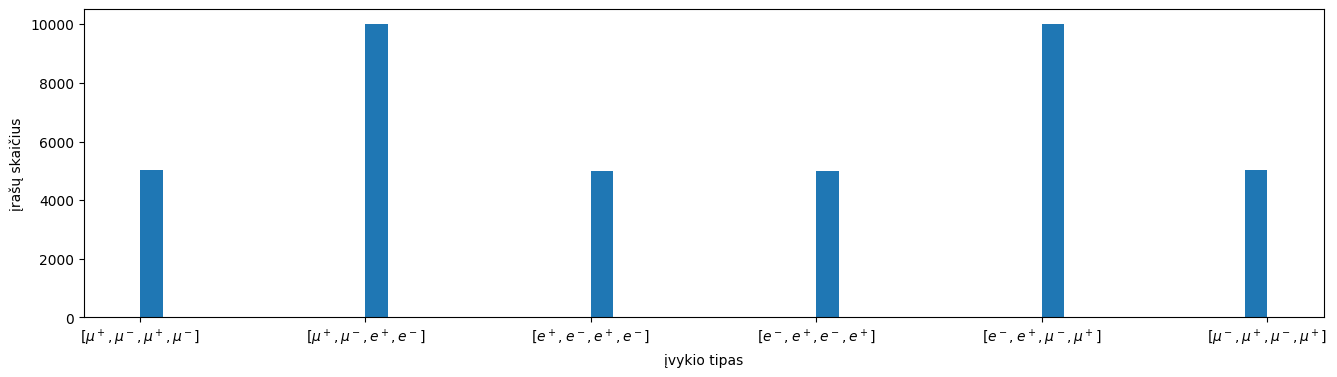

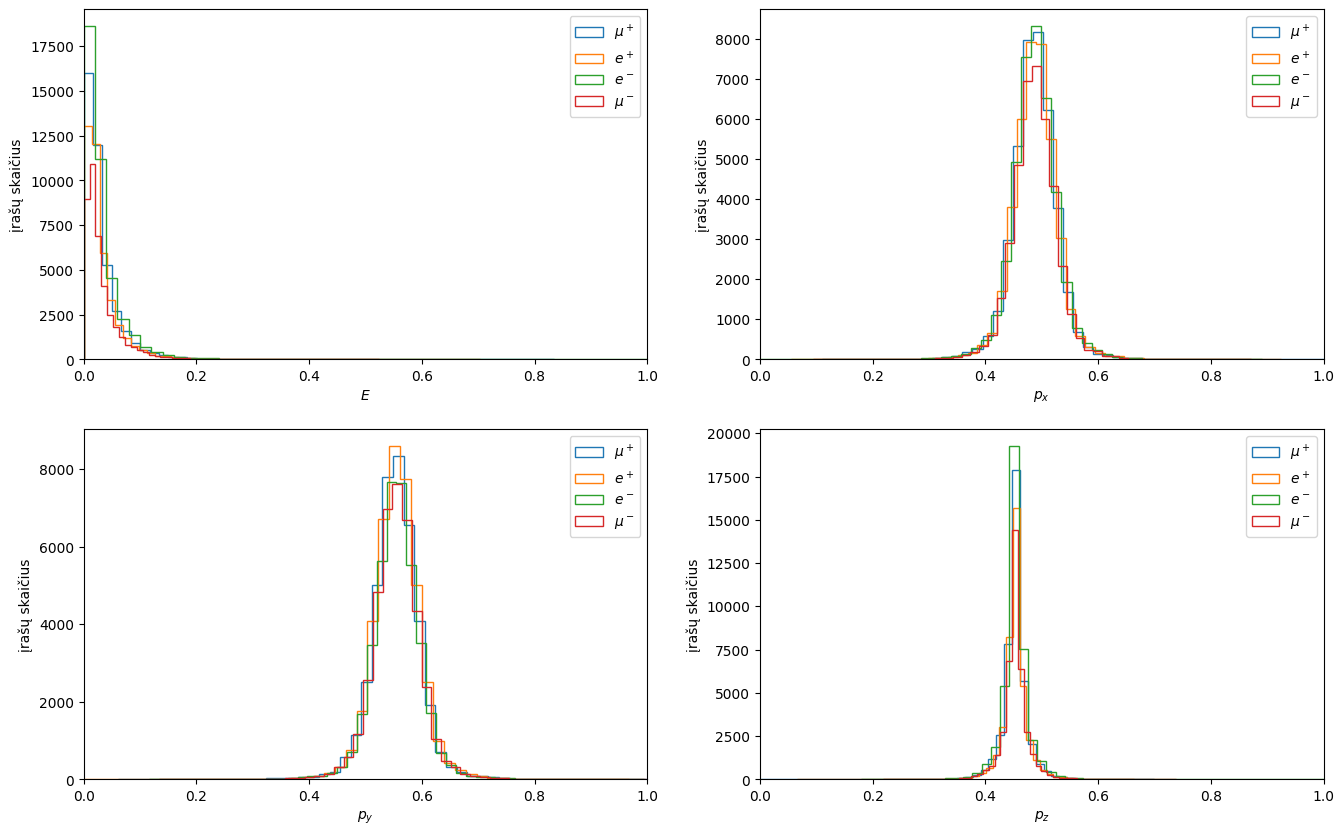

In [14]:
plot_histos(X_codes, X_props, normal_scale=True)

# GAN

In [69]:
noise_len = 64
code_len = X_codes.shape[1]
prop_len = X_props.shape[1]

noise_len, code_len, prop_len

(64, 6, 16)

In [70]:
def gaussian_kernel(x1, x2, beta = 1.0):
    r = tf.transpose(x1)
    r = tf.expand_dims(r, 2)
    return tf.reduce_sum(K.exp( -beta * K.square(r - x2)), axis=-1)
  
def MMD(x1, x2, beta = 1.0):
    """
    maximum mean discrepancy (MMD) based on Gaussian kernel
    function for keras models (theano or tensorflow backend)
    
    - Gretton, Arthur, et al. "A kernel method for the two-sample-problem."
    Advances in neural information processing systems. 2007.
    """

    x1x1 = gaussian_kernel(x1, x1, beta)
    x1x2 = gaussian_kernel(x1, x2, beta)
    x2x2 = gaussian_kernel(x2, x2, beta)
    diff = tf.reduce_mean(x1x1) - 2 * tf.reduce_mean(x1x2) + tf.reduce_mean(x2x2)
    return diff

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 dense_18 (Dense)               (None, 128)          8320        ['input_9[0][0]']                
                                                                                                  
 dense_19 (Dense)               (None, 256)          33024       ['dense_18[0][0]']               
                                                                                                  
 dense_20 (Dense)               (None, 512)          131584      ['dense_19[0][0]']               
                                                                                            

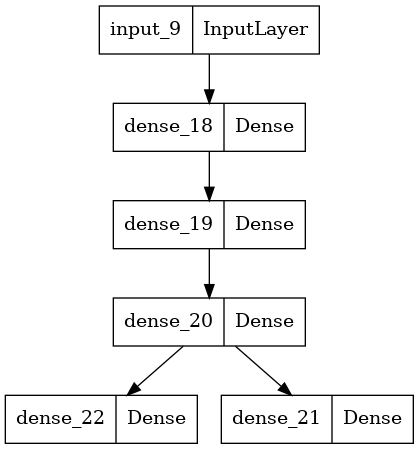

In [71]:
def create_generator():
    
    inp = Input(shape=(noise_len,))
    
    x = Dense(128, activation='leaky_relu', kernel_initializer='he_normal')(inp)
    x = Dense(256, activation='leaky_relu', kernel_initializer='he_normal')(x)
    x = Dense(512, activation='leaky_relu', kernel_initializer='he_normal')(x)
    
    prop = Dense(activation='linear', units=prop_len)(x)
    code = Dense(code_len, activation='softmax')(x)
    
    generator = Model(inputs=inp, outputs=[code, prop])
    generator.compile(loss='mse', optimizer='adam')
    
    return generator

generator = create_generator()
generator.summary()
plot_model(generator, to_file = 'generator.png')


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 6)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 16)]         0           []                               
                                                                                                  
 concatenate_2 (Concatenate)    (None, 22)           0           ['input_10[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 dense_23 (Dense)               (None, 512)          11776       ['concatenate_2[0][0]']    

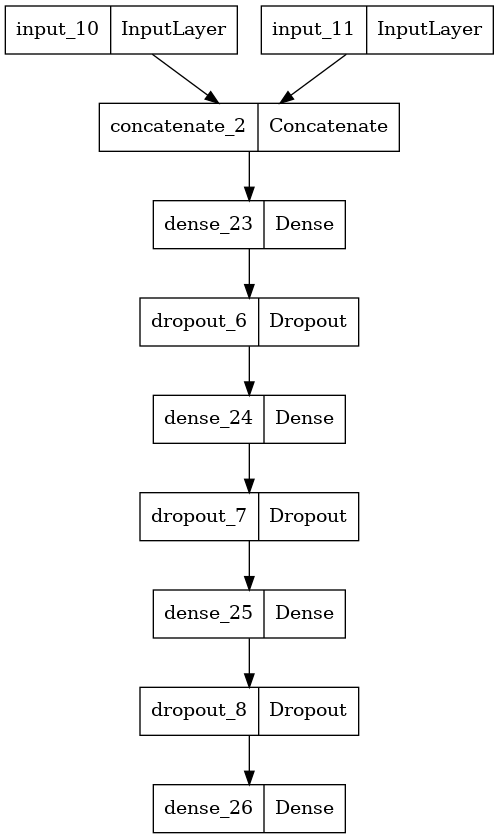

In [72]:
def create_discriminator():

    inp_code = Input(shape=(code_len,))
    inp_prop = Input(shape=(prop_len,))
    
    x = Concatenate()((inp_code, inp_prop))
    x = Dense(512, activation='leaky_relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='leaky_relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='leaky_relu', kernel_initializer='he_normal')(x)
    x = Dropout(0.3)(x)
    
    out = Dense(1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[inp_code, inp_prop], outputs=out)
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    
    return discriminator

discriminator = create_discriminator()
discriminator.summary()
plot_model(discriminator, to_file = 'discriminator.png')


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 model_6 (Functional)           [(None, 6),          184214      ['input_12[0][0]']               
                                 (None, 16)]                                                      
                                                                                                  
 model_7 (Functional)           (None, 1)            176129      ['model_6[0][0]',                
                                                                  'model_6[0][1]']                
                                                                                            

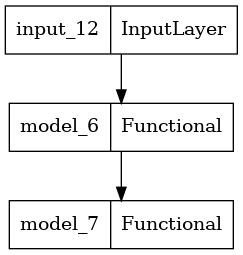

In [73]:
def create_gan(discriminator, generator):
    
    discriminator.trainable = False
    gan_input = Input(shape=(noise_len,))
    code, prop = generator(gan_input)
    gan_output = discriminator([code, prop])
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
    
    return gan

gan = create_gan(discriminator, generator)
gan.summary()
plot_model(gan, to_file = 'gan.png')


In [74]:
loss = dict(d=[], g=[])

In [75]:
epochs = 10
batch_size = 256
    
with tqdm(total=batch_size) as bbar:
    
    for e in tqdm(range(1, epochs + 1)):

        bbar.reset()

        for _ in range(batch_size):

            # Generate random noise as an input to initialize the generator
            noise = np.random.normal(0, 1, [batch_size, noise_len])

            # Generate fake particles from noised input
            fake_batch = generator.predict(noise)

            # Get a random set of real particles
            idx = np.random.randint(low = 0,high = X_codes.shape[0], size = batch_size)
            real_batch = X_codes[idx], X_props[idx]

            # Construct different batches of real and fake data 
            X = np.concatenate([real_batch[0], fake_batch[0]]), np.concatenate([real_batch[1], fake_batch[1]])

            # Labels for generated and real data
            Y = np.zeros(2 * batch_size)
            Y[:batch_size] = 0.90

            # Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True

            l = discriminator.train_on_batch(X, Y)
            loss['d'].append(l)

            # Tricking the noised input of the Generator as real data
            X_ = np.random.normal(0, 1, [batch_size, noise_len])
            Y_ = np.ones(batch_size)

            # During the training of gan, the weights of discriminator should be fixed. 
            # We can enforce that by setting the trainable flag
            discriminator.trainable = False

            # Training the GAN by alternating the training of the Discriminator 
            # and training the chained GAN model with Discriminator’s weights freezed.

            l = gan.train_on_batch(X_, Y_)
            loss['g'].append(l)

            bbar.update(1)


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 960us/step


8/8 [==============================] - 0s 952us/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 898us/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 974us/step


8/8 [==============================] - 0s 986us/step


8/8 [==============================] - 0s 962us/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 975us/step


8/8 [==============================] - 0s 1ms/step


8/8 [==============================] - 0s 1ms/step


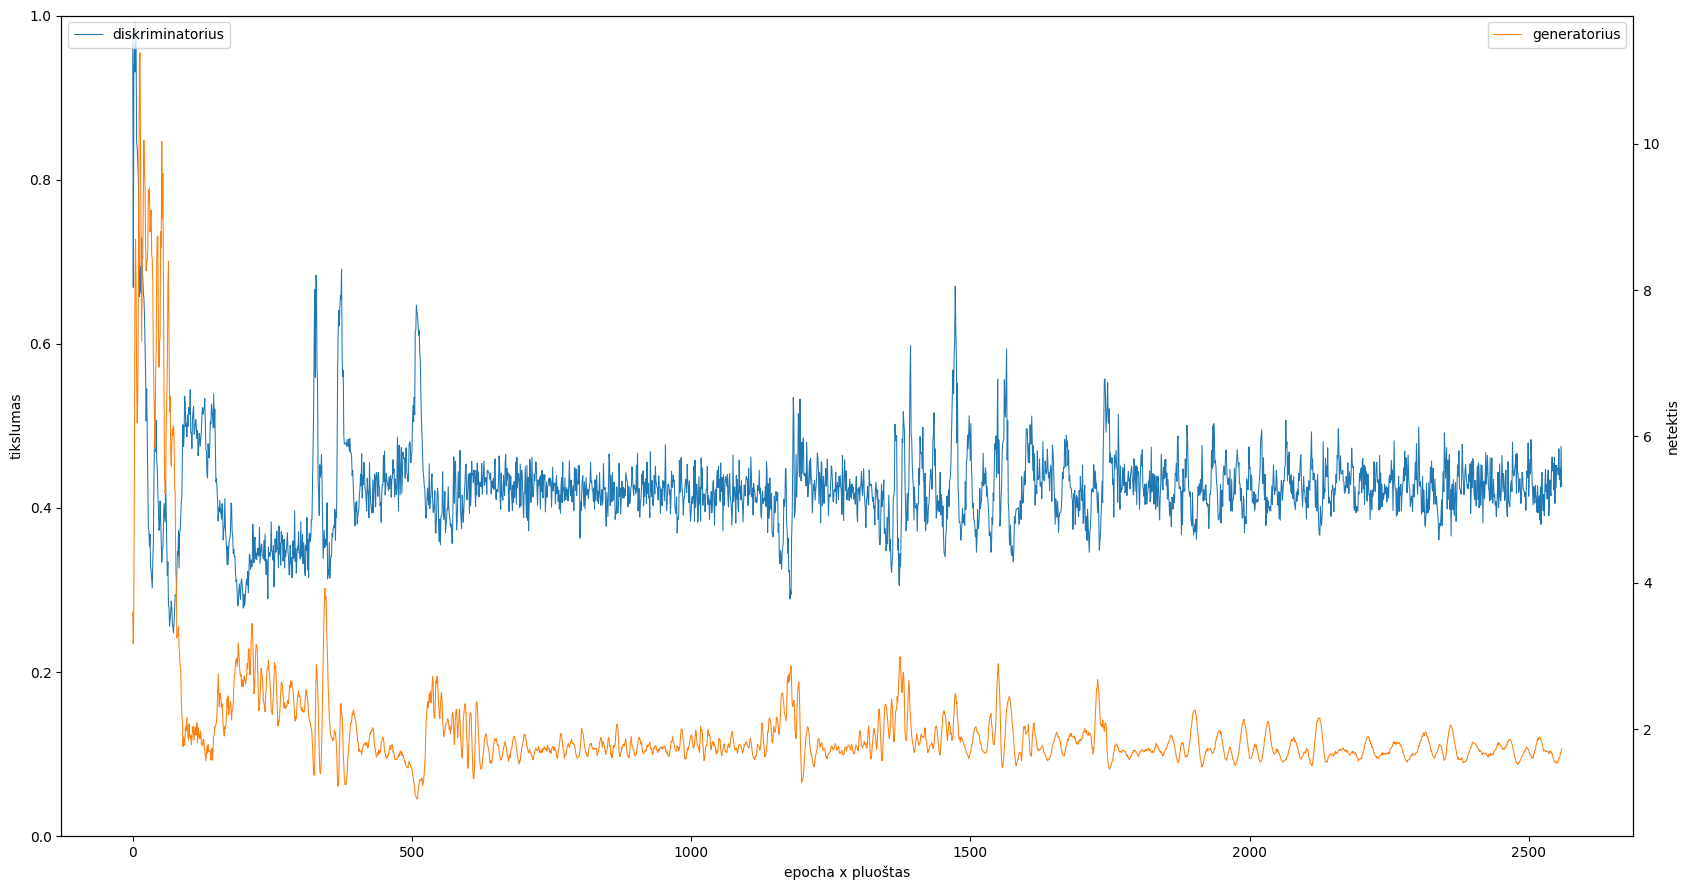

In [78]:
fig, ax1 = plt.subplots(figsize=(17,9))
ax2 = ax1.twinx()

ax1.plot(loss['d'], color='C0', linewidth=0.75, label='diskriminatorius')
ax1.set_ylabel('tikslumas')
ax1.set_ylim((0., 1.))
ax1.legend(loc='upper left')

ax2.plot(loss['g'], color='C1', linewidth=0.75, label='generatorius')
ax2.set_ylabel('netektis')
ax2.legend(loc='upper right')
ax1.set_xlabel('epocha x pluoštas')

plt.tight_layout()
plt.show()

In [89]:
examples = 40000
    
noise = np.random.normal(loc = 0, scale = 1, size = [examples, noise_len])
G_codes, G_props = generator.predict(noise)
G_codes.shape, G_props.shape

1250/1250 [==============================] - 1s 890us/step


((40000, 6), (40000, 16))

/tmp/ipykernel_1679309/2879661403.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


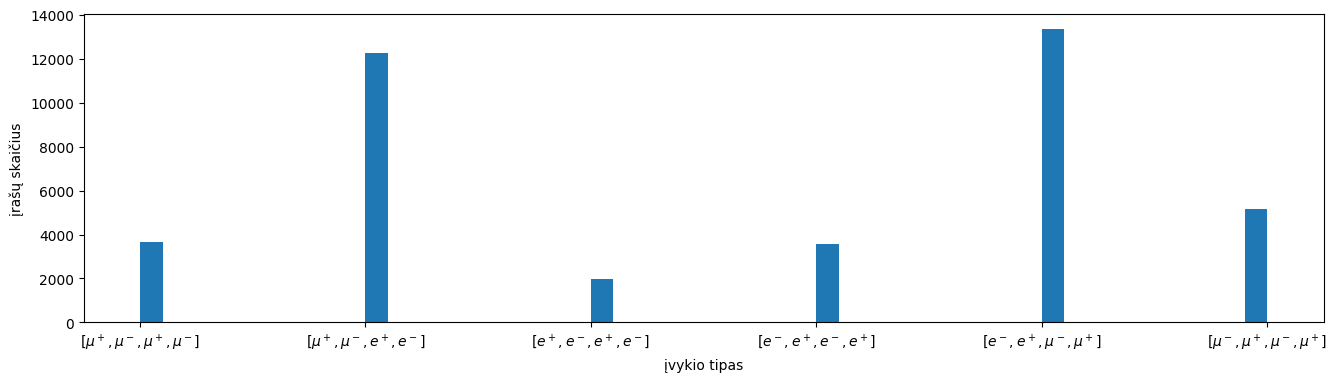

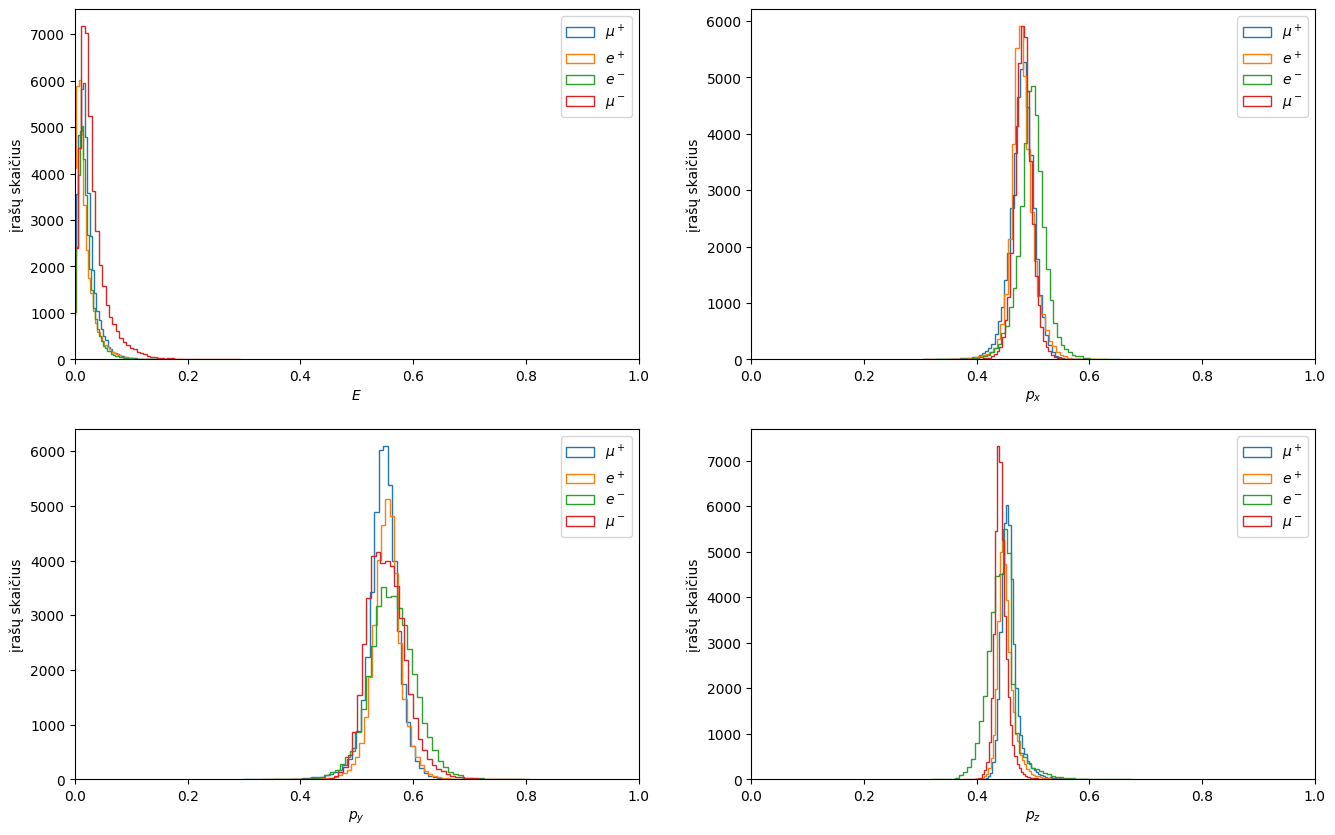

In [90]:
plot_histos(G_codes, G_props, normal_scale=True)

In [52]:
generator.save('generator_model')

INFO:tensorflow:Assets written to: generator_model/assets


INFO:tensorflow:Assets written to: generator_model/assets


In [88]:
generator = keras.models.load_model('generator_model')

In [91]:
G_stack = np.append(G_props[:,0:4], G_props[:,4:8], axis = 0)
G_stack = np.append(G_stack, G_props[:,8:12], axis = 0)
G_stack = np.append(G_stack, G_props[:,12:16], axis = 0)
G_stack.shape

(160000, 4)

In [92]:
x_ = scaler.inverse_transform(G_stack)
c = x_.shape[0] // 4
x = x_[0:c]
x = np.append(x, x_[c:c*2], axis=1)
x = np.append(x, x_[c*2:c*3], axis=1)
x = np.append(x, x_[c*3:c*4], axis=1)

y = particle_types[np.argmax(G_codes, axis=1)]
x.shape, y.shape

((40000, 16), (40000, 4))

In [93]:
data_gen = y[:,0:1]
data_gen = np.append(data_gen, x[:,0:4], axis=1)

data_gen = np.append(data_gen, y[:,1:2], axis=1)
data_gen = np.append(data_gen, x[:,4:8], axis=1)

data_gen = np.append(data_gen, y[:,2:3], axis=1)
data_gen = np.append(data_gen, x[:,8:12], axis=1)

data_gen = np.append(data_gen, y[:,3:4], axis=1)
data_gen = np.append(data_gen, x[:,12:16], axis=1)

data_gen = pd.DataFrame(data_gen, columns=data_raw.columns)

data_gen.shape

(40000, 20)

In [94]:
data_gen

,pdg1,E1,p1x,p1y,p1z,pdg2,E2,p2x,p2y,p2z,pdg3,E3,p3x,p3y,p3z,pdg4,E4,p4x,p4y,p4z
0,-13.0,103.860176,-23.521164,-32.298706,-86.880325,13.0,106.051506,23.729513,42.195160,-76.131798,-11.0,45.342884,-3.234306,-11.727121,-90.013657,11.0,72.519508,-6.152935,6.369932,-11.974483
1,13.0,115.553055,-19.451469,-48.699394,129.243805,-13.0,191.720337,20.872532,12.864117,76.972496,13.0,47.045403,-16.082882,72.344681,-67.834480,-13.0,60.748222,2.953841,-36.790947,114.950584
2,-13.0,2.473316,41.846806,5.601978,72.893509,13.0,55.895645,-3.125174,-10.452768,106.040749,-13.0,0.124171,16.794733,-47.874924,-63.529724,13.0,42.893890,-39.874088,13.576662,8.315637
3,11.0,93.158516,-4.513699,-44.258343,-54.062679,-11.0,88.465584,15.051250,39.325439,-33.842163,11.0,13.149028,-27.109770,-3.558505,-50.632427,-11.0,36.309483,15.590358,0.453711,40.541977
4,11.0,45.534534,30.688869,25.113016,-157.650452,-11.0,37.681393,-19.165854,13.997560,11.326887,13.0,130.918030,-3.065839,-43.208179,-117.765633,-13.0,53.705544,-30.724857,-3.888516,-5.507798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,-13.0,16.688347,30.304539,25.395502,-171.841263,13.0,8.801716,2.370701,-9.856038,53.005421,-13.0,72.754150,7.874358,-49.670498,-9.208382,13.0,31.905815,-27.463968,18.273218,34.041058
39996,-13.0,133.154419,-73.116516,-111.064728,198.111725,13.0,166.675781,-1.767809,55.413162,-56.268036,-11.0,84.059868,22.935921,48.934467,75.449966,11.0,92.897133,51.066925,15.170256,41.810871
39997,-13.0,68.848175,8.154650,-13.834553,-33.766762,13.0,39.694847,-19.115763,19.930161,-32.211697,-11.0,48.225925,12.590537,-1.841712,-34.059444,11.0,38.706089,-8.320716,-11.573941,-37.451786
39998,11.0,32.626011,14.948905,33.801689,-152.492126,-11.0,37.414089,-27.881245,-6.754797,23.783113,13.0,83.523636,13.121628,-51.720829,-48.528496,-13.0,45.528709,-16.071297,28.902651,69.343018


In [95]:
m_real = get_m_values(data_raw)
m_gen = get_m_values(data_gen)

/home/valdo/.local/share/virtualenvs/event_simulator-maQXyZus/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


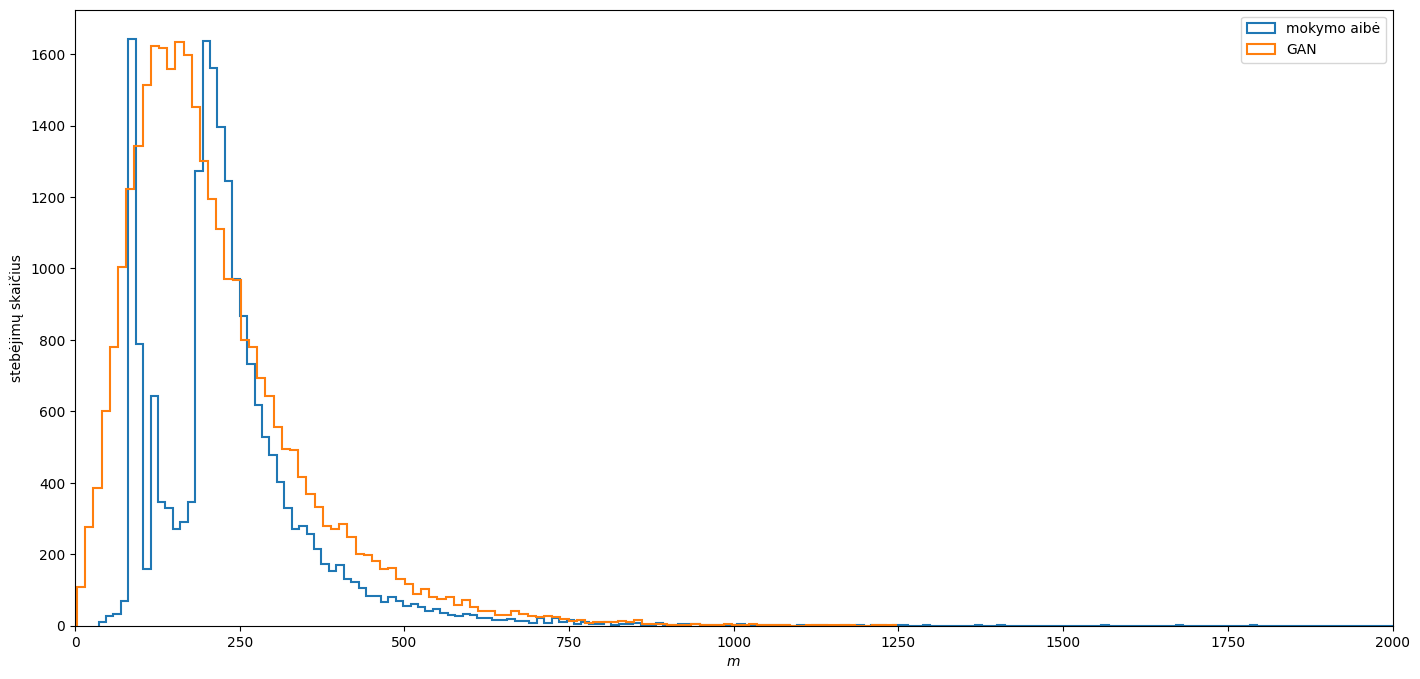

In [104]:
plt.figure(figsize=(17, 8))
plt.hist(m_real, bins=200, histtype='step', linewidth=1.5, fill=False, label="mokymo aibė")
plt.hist(m_gen, bins=100, histtype='step', linewidth=1.5, fill=False, label="GAN")
plt.xlim((0, 2000))
plt.legend()
plt.xlabel("$m$")
plt.ylabel("stebėjimų skaičius")
plt.show()